In [1]:
# In a true DataSphere fashion, we don't specify the commit. The rest of the environment will evolve, so what's the point?
%pip install git+https://github.com/google/jax-md.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/google/jax-md.git to /tmp/pip-req-build-85a2l6dd
  Running command git clone -q https://github.com/google/jax-md.git /tmp/pip-req-build-85a2l6dd


In [2]:
from jax import random, lax
from jax.experimental import optimizers
import jax.numpy as jnp
import numpy as onp
import jax.scipy.stats.norm
from jax.api import jit, jacfwd, vmap, value_and_grad, pmap
#from jax.config import config
#config.update('jax_enable_x64', True)
#config.update("jax_debug_nans", True)
from jax_md import simulate, energy, minimize, quantity
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d
from utils import ProgressIter, draw_system, draw_lattice, normalise_phase
from simulation import (
    simulate_with_parameters, init_at_temperature, N_A, N_B,
    compute_normalised_phase,
    get_angular_momentum, get_momentum, get_temperature)
from utils import ProgressIter, draw_system, lennard_jones_pair_no_cutoff, draw_lattice, params_to_matrices
from simulation import E_0, eV, species, displacement_fun, shift_fun

/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
m_A = 3.5
m_B = 1.5
mass = jnp.array([m_A]*N_A+[m_B]*N_B, dtype=jnp.float32)

In [4]:
lattice_austenite_default = jnp.load("lattice_austenite.npz")["lattice_austenite"]
lattice_martensite_default = jnp.load("lattice_martensite.npz")["lattice_martensite"]

In [5]:
def params_from_vector(params_vector):
    e_aa, e_bb, e_ab, s_aa, s_bb, s_ab = params_vector
    epsilon=jax.numpy.array([
        [e_aa, e_ab],
        [e_ab, e_bb]], dtype=jnp.float32)
    sigma = jax.numpy.array([
        [s_aa, s_ab],
        [s_ab, s_bb]
    ], dtype=jnp.float32)
    return epsilon, sigma

class Simulator:
    def __init__(self, key, initial_positions, initial_velocities, iterations=200):
        self.rng = key
        self.initial_positions = initial_positions
        self.initial_velocities = initial_velocities
        self.iterations = iterations
    
    def simulate_single(self, params_vector, subkey=None):
        if subkey is None:
            self.rng, subkey = jax.random.split(self.rng)
        potential_params = params_from_vector(params_vector)
        init_fn, apply_fn, energy_fun = simulate_with_parameters(*potential_params)
        def trajectory_step(state, _):
            new_state = apply_fn(state)
            return new_state, new_state.position
        intial_state = init_fn(subkey, self.initial_positions, self.initial_velocities, mass=mass)
        return lax.scan(trajectory_step, initial_state, xs=None, length=self.iterations)[1]
    
    def simulate_batch(self, params_vectors):
        self.rng, subkey = jax.random.split(self.rng)
        batch_keys = jax.random.split(subkey, num=params_vectors.shape[0])
        return vmap(self.simulate_single)(params_vectors, batch_keys)

In [6]:
rng = jax.random.PRNGKey(12412)
default_params = onp.array([1.14, 0.217, 1., 0.9, 0.6, 0.865], dtype=onp.float32)
init_fn, apply_fn, energy_fun = simulate_with_parameters(*params_from_vector(default_params))
rng, subkey = jax.random.split(rng)
initial_state = init_at_temperature(subkey, lattice_austenite_default, 10000, init_fn, mass)

/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [7]:
rng, subkey = jax.random.split(rng)
simulator = Simulator(subkey, initial_state.position, initial_state.velocity, 10000)

In [8]:
example_trajectory = simulator.simulate_single(default_params)

# Task 2
You are given a trajectory generated with `simulator.simulate_single(unknown_params)`, find the parameters of the Lennard-Jones potential. They all lie in `[0.3, 1.3]`


In the case of questions, feel free to contact [Nikita Kazeev](https://t.me/kazeevn)

In [10]:
with onp.load("task_2_target.npz", allow_pickle=False ) as input_file:
    observed_trajectory = input_file["observed_trajectory"]

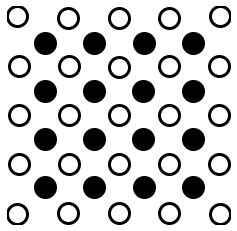

In [11]:
draw_system(initial_state);

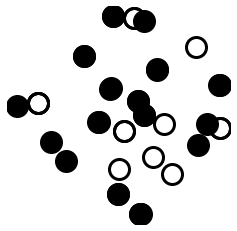

In [12]:
draw_lattice(observed_trajectory[-1]);

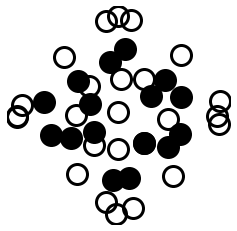

In [13]:
draw_lattice(example_trajectory[-1]);